In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, jaccard_score, log_loss, f1_score

In [2]:
%matplotlib inline

### Impor Dataset

In [3]:
df = pd.read_csv('dataset/iris_1.data', header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### wrangling and pre-proccessing

In [4]:
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [5]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df.species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [7]:
df['species'] = df['species'].str.replace('Iris-', '')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [8]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [9]:
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### EDA

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

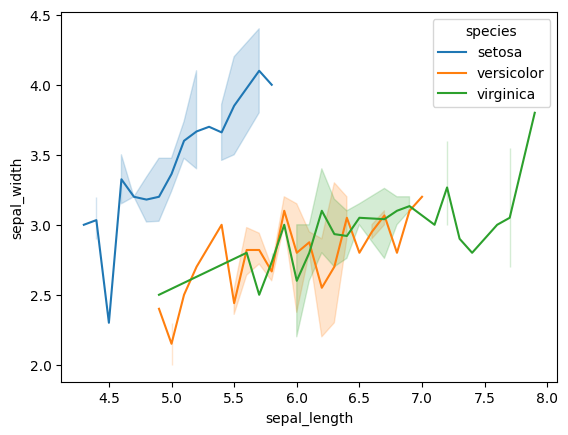

In [11]:
sns.lineplot(data=df, x='sepal_length', y='sepal_width', hue='species')

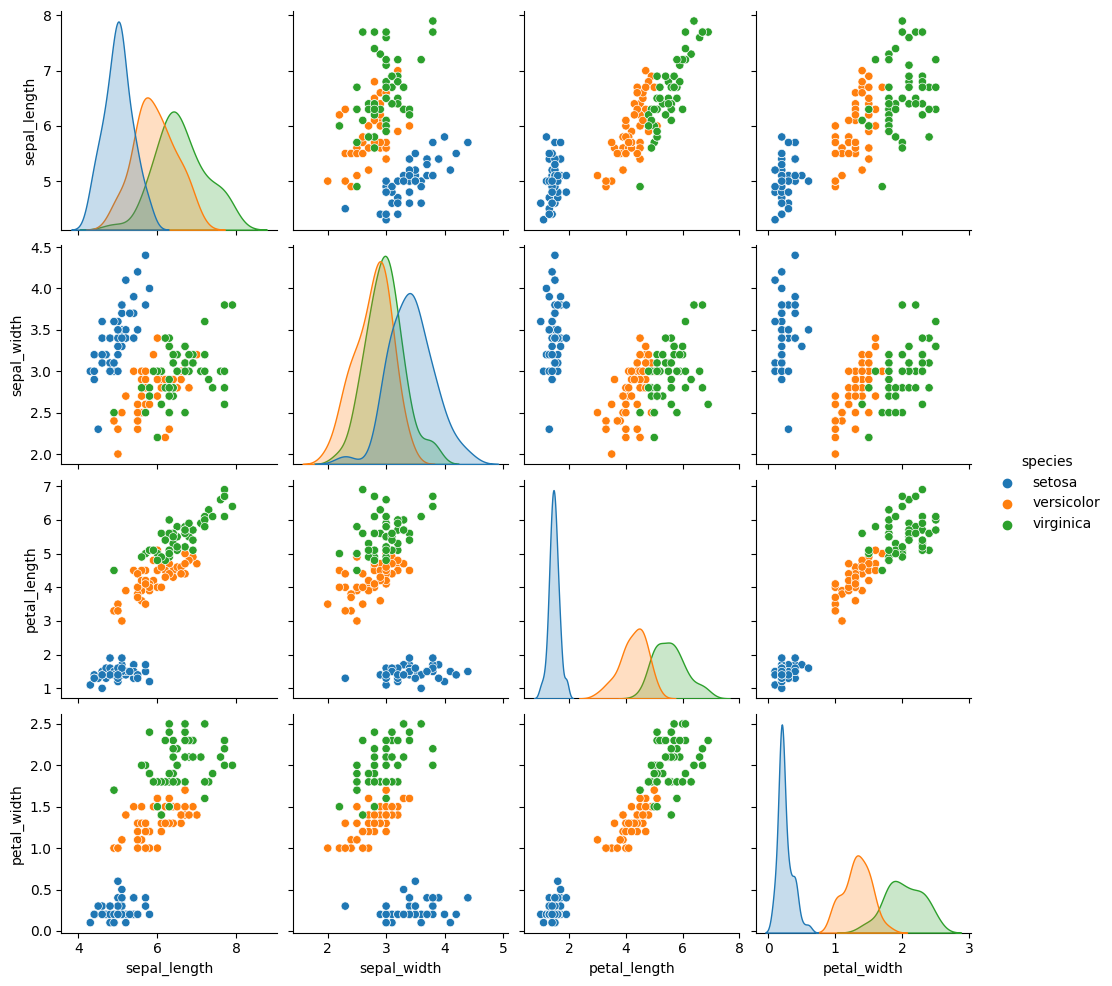

In [12]:
sns.pairplot(df, hue='species')

### Feature engineering

In [13]:
df['ps_area'] = df['sepal_length'] * df['petal_width']
df['diagonal'] = np.sqrt(df['petal_length']**2 + df['petal_width']**2)
df['area'] = df['petal_length'] * df['petal_width']

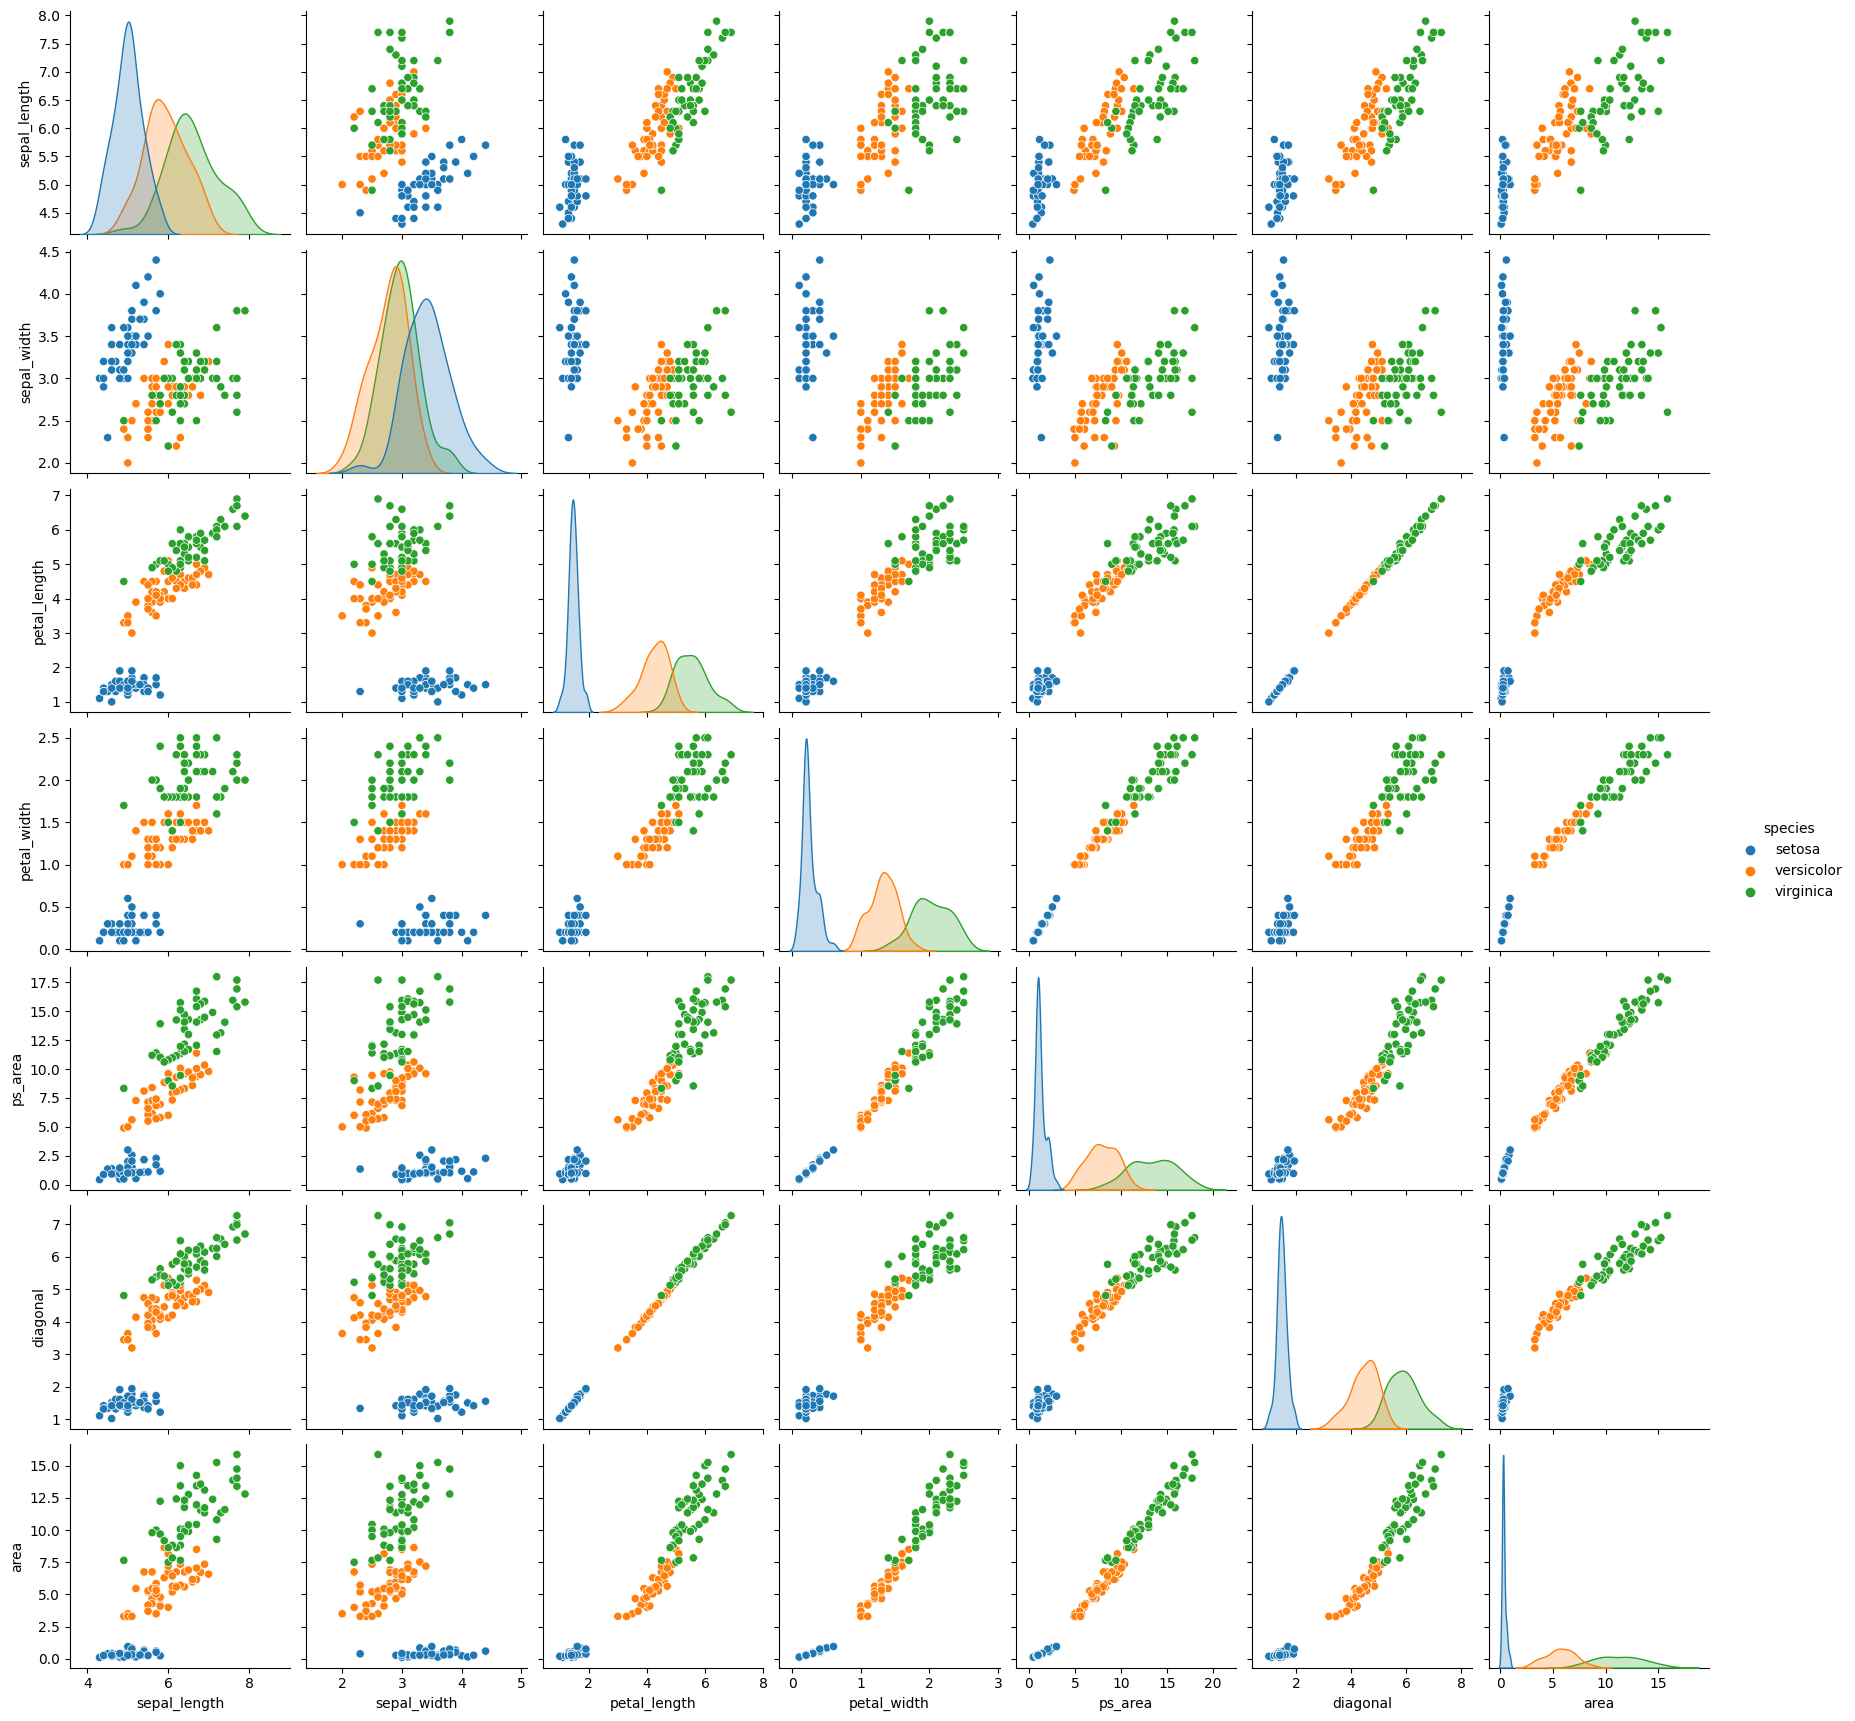

In [14]:
sns.pairplot(df, hue='species')

In [15]:
df.corr(numeric_only=True)[df.corr(numeric_only=True) > 0.5]

,sepal_length,sepal_width,petal_length,petal_width,ps_area,diagonal,area
sepal_length,1.000000,NaN,0.871754,0.817941,0.884524,0.868576,0.857300
sepal_width,NaN,1.0,NaN,NaN,NaN,NaN,NaN
petal_length,0.871754,NaN,1.000000,0.962865,0.963512,0.999380,0.958422
petal_width,0.817941,NaN,0.962865,1.000000,0.986294,0.971661,0.980333
ps_area,0.884524,NaN,0.963512,0.986294,1.000000,0.970695,0.992889
diagonal,0.868576,NaN,0.999380,0.971661,0.970695,1.000000,0.965762
area,0.857300,NaN,0.958422,0.980333,0.992889,0.965762,1.000000


In [16]:
from scipy import stats
rel = [['petal_length','sepal_length'], ['petal_width','sepal_length'], ['petal_length', 'petal_width']]
for i in rel:
    coef, pval = stats.pearsonr(df[i[0]], df[i[1]])
    print(f'{i} => p-value = {pval}')

['petal_length', 'sepal_length'] => p-value = 1.0386674194498827e-47
['petal_width', 'sepal_length'] => p-value = 2.325498079793381e-37
['petal_length', 'petal_width'] => p-value = 4.675003907328653e-86


In [17]:
coef, pval = stats.f_oneway(df['petal_length'], df['sepal_length'], df['petal_width'])

In [18]:
print(coef, pval, sep='\n')

555.480696675312
6.416687045856798e-122


### Machine learning implementing

In [19]:
df['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [20]:
# label encodeing
df['species_target'] = df['species'].map({'setosa':'0', 'versicolor':'1', 'virginica':'2'})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,ps_area,diagonal,area,species_target
0,5.1,3.5,1.4,0.2,setosa,1.02,1.414214,0.28,0
1,4.9,3.0,1.4,0.2,setosa,0.98,1.414214,0.28,0
2,4.7,3.2,1.3,0.2,setosa,0.94,1.315295,0.26,0
3,4.6,3.1,1.5,0.2,setosa,0.92,1.513275,0.30,0
4,5.0,3.6,1.4,0.2,setosa,1.00,1.414214,0.28,0


In [21]:
df['species_target'] = df['species_target'].astype('float')

In [22]:
features =  ['petal_length', 'petal_width', 'area', 'diagonal', 'ps_area']
x = df[features]
y = df['species_target']

In [23]:
x = StandardScaler().fit_transform(x)

In [24]:
x[0:5]

array([[-1.34022653, -1.3154443 , -1.17404107, -1.34039653, -1.2360241 ],
       [-1.34022653, -1.3154443 , -1.17404107, -1.34039653, -1.24362931],
       [-1.39706395, -1.3154443 , -1.17829941, -1.39258431, -1.25123452],
       [-1.2833891 , -1.3154443 , -1.16978272, -1.28813378, -1.25503713],
       [-1.34022653, -1.3154443 , -1.17404107, -1.34039653, -1.23982671]])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [26]:
print(x_train.shape, y_train.shape, sep='\n')

(90, 5)
(90,)


In [27]:
y.dtype

dtype('float64')

In [28]:
x.dtype

dtype('float64')

## SVM support vector machine

In [29]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
s_ml = SVC()

In [30]:
grid = GridSearchCV(s_ml ,parameters,cv=5)

In [31]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [32]:
grid.best_params_

{'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}

In [33]:
grid.best_score_

0.9444444444444444

In [34]:
grid.score(x_test, y_test)

0.9833333333333333

In [35]:
jaccard_score(y_test, grid.predict(x_test), average=None)

array([1.        , 0.95      , 0.94444444])

In [36]:
grid.score(x_train, y_train)

0.9444444444444444

In [37]:
target_names = ['setosa', 'versicolor', 'virginica']
print(classification_report(y_test, grid.predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       0.95      1.00      0.97        19
   virginica       1.00      0.94      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [38]:
mat = confusion_matrix(y_test, grid.predict(x_test))

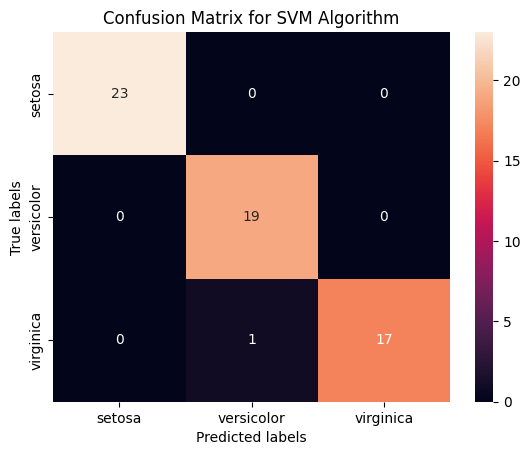

In [39]:
ax = plt.subplot()
sns.heatmap(mat, annot=True, ax=ax)
ax.set_title('Confusion Matrix for SVM Algorithm')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(['setosa', 'versicolor', 'virginica'])
ax.set_yticklabels(['setosa', 'versicolor', 'virginica'])
plt.show()

## KNN

In [40]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
k_ml = KNeighborsClassifier()
k_grid = GridSearchCV(k_ml, parameters, cv=5)
k_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [41]:
k_grid.best_score_

0.9333333333333333

In [42]:
k_grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}

In [43]:
k_grid.score(x_test, y_test)

1.0

In [44]:
print(classification_report(y_test, k_grid.predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       1.00      1.00      1.00        19
   virginica       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [45]:
mat = confusion_matrix(y_test, k_grid.predict(x_test))

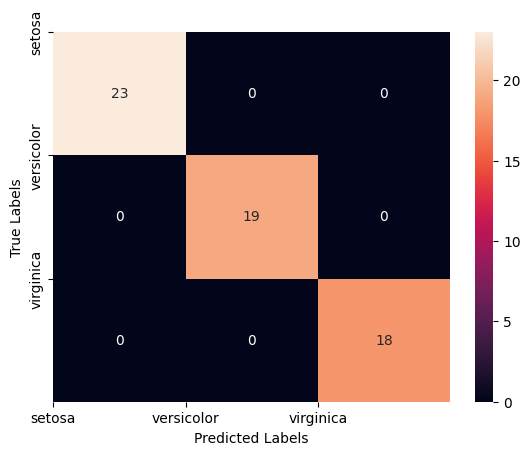

In [46]:
sns.heatmap(mat, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0, 1, 2], labels=['setosa', 'versicolor', 'virginica'])
plt.yticks(ticks=[0, 1, 2], labels=['setosa', 'versicolor', 'virginica'])
plt.show()

## Tree

In [47]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

t_ml = DecisionTreeClassifier()
t_grid = GridSearchCV(t_ml, parameters, cv=5)
t_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [48]:
t_grid.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'splitter': 'best'}

In [49]:
t_grid.best_score_

0.9666666666666668

In [50]:
print(classification_report(y_test, t_grid.predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       0.95      1.00      0.97        19
   virginica       1.00      0.94      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



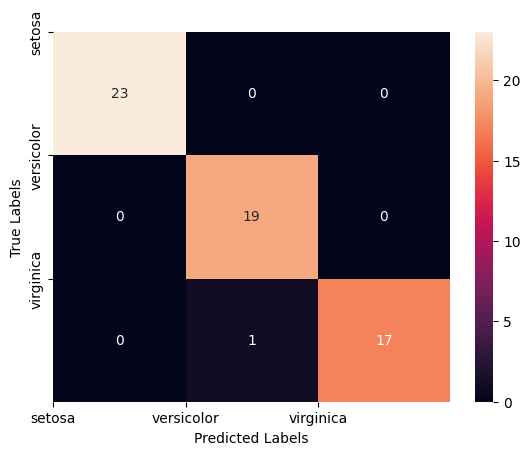

In [51]:
mat = confusion_matrix(y_test, t_grid.predict(x_test))

sns.heatmap(mat, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0,1,2], labels=target_names)
plt.yticks(ticks=[0,1,2], labels=target_names)

plt.show()

In [52]:
t_grid.score(x_test, y_test)

0.9833333333333333

## Logestic Regression

In [53]:
parameters = {"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}
l_ml = LogisticRegression()
l_grid = GridSearchCV(l_ml, parameters, cv=5)
l_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [54]:
l_grid.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [55]:
l_grid.best_score_

0.9333333333333333

In [56]:
print(classification_report(y_test, l_grid.predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       0.95      1.00      0.97        19
   virginica       1.00      0.94      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [57]:
mat = confusion_matrix(y_test, l_grid.predict(x_test))

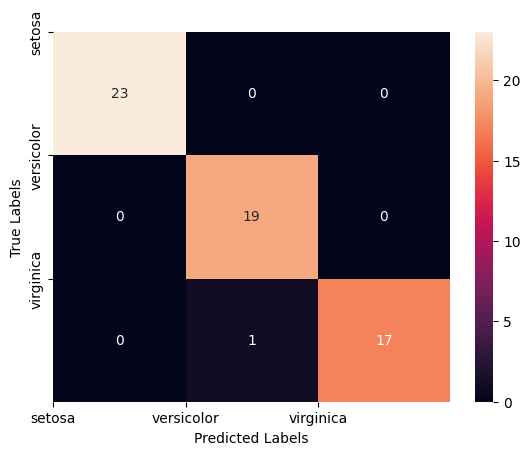

In [58]:
sns.heatmap(mat, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0,1,2], labels=target_names)
plt.yticks(ticks=[0,1,2], labels=target_names)

plt.show()

defining confusion matrix plot for reusing

In [59]:
def conf(matrix):
    sns.heatmap(matrix, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=[0,1,2], labels=target_names)
    plt.yticks(ticks=[0,1,2], labels=target_names)
    plt.show()

## KMeans

In [60]:
parameters = {'n_clusters':[3], 'init':['k-means++', 'random'], 'n_init':['auto', 5, 10]}
km_ml = KMeans()
km_grid = GridSearchCV(km_ml, parameters, cv=5)
km_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'init': ['k-means++', 'random'], 'n_clusters': [3],
                         'n_init': ['auto', 5, 10]})

In [61]:
km_grid.best_params_

{'init': 'k-means++', 'n_clusters': 3, 'n_init': 5}

In [62]:
km_grid.best_score_

-6.878685755362793

**this is so bad**

In [63]:
km_grid.predict(x_test)

array([0, 1, 2, 0, 0, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 1,
       1, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0], dtype=int32)

In [64]:
print(classification_report(y_true=y_test, y_pred=km_grid.predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

      setosa       0.00      0.00      0.00        23
  versicolor       0.00      0.00      0.00        19
   virginica       1.00      0.94      0.97        18

    accuracy                           0.28        60
   macro avg       0.33      0.31      0.32        60
weighted avg       0.30      0.28      0.29        60



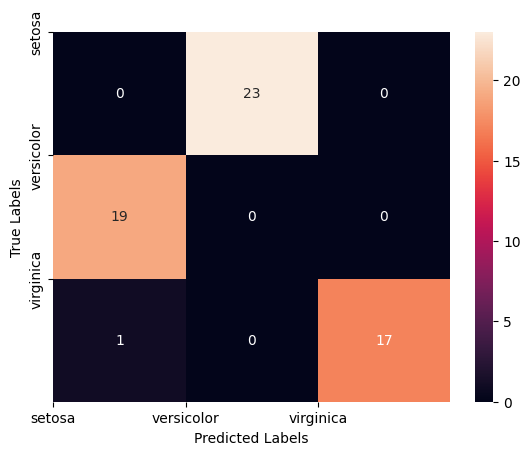

In [65]:
mat = confusion_matrix(y_test, km_grid.predict(x_test))

conf(mat)

**we have to change our approach for clustering algorithem**

**why clustering did not work ?**